### Imports

In [1]:
import numpy as np
from specmf.models import Graph, MultiFidelityModel
from specmf.utils import error_analysis, load_model_config
from specmf.data import load_data
from specmf.plot import *

In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>

### Data loading

In [3]:
dataset_name = "inclusion-qoi"

x_LF, x_HF, normalization_vars = load_data(
        dataset_name,
        preprocess=True,
        normalize=True,
        return_normalization_vars=True,
        flatten=True,
)

print(f"{x_LF.shape=}", f"{x_HF.shape=}")

Loading inclusion QoIs data ...
x_LF.shape=(5835, 5) x_HF.shape=(5835, 5)


### Plot data 

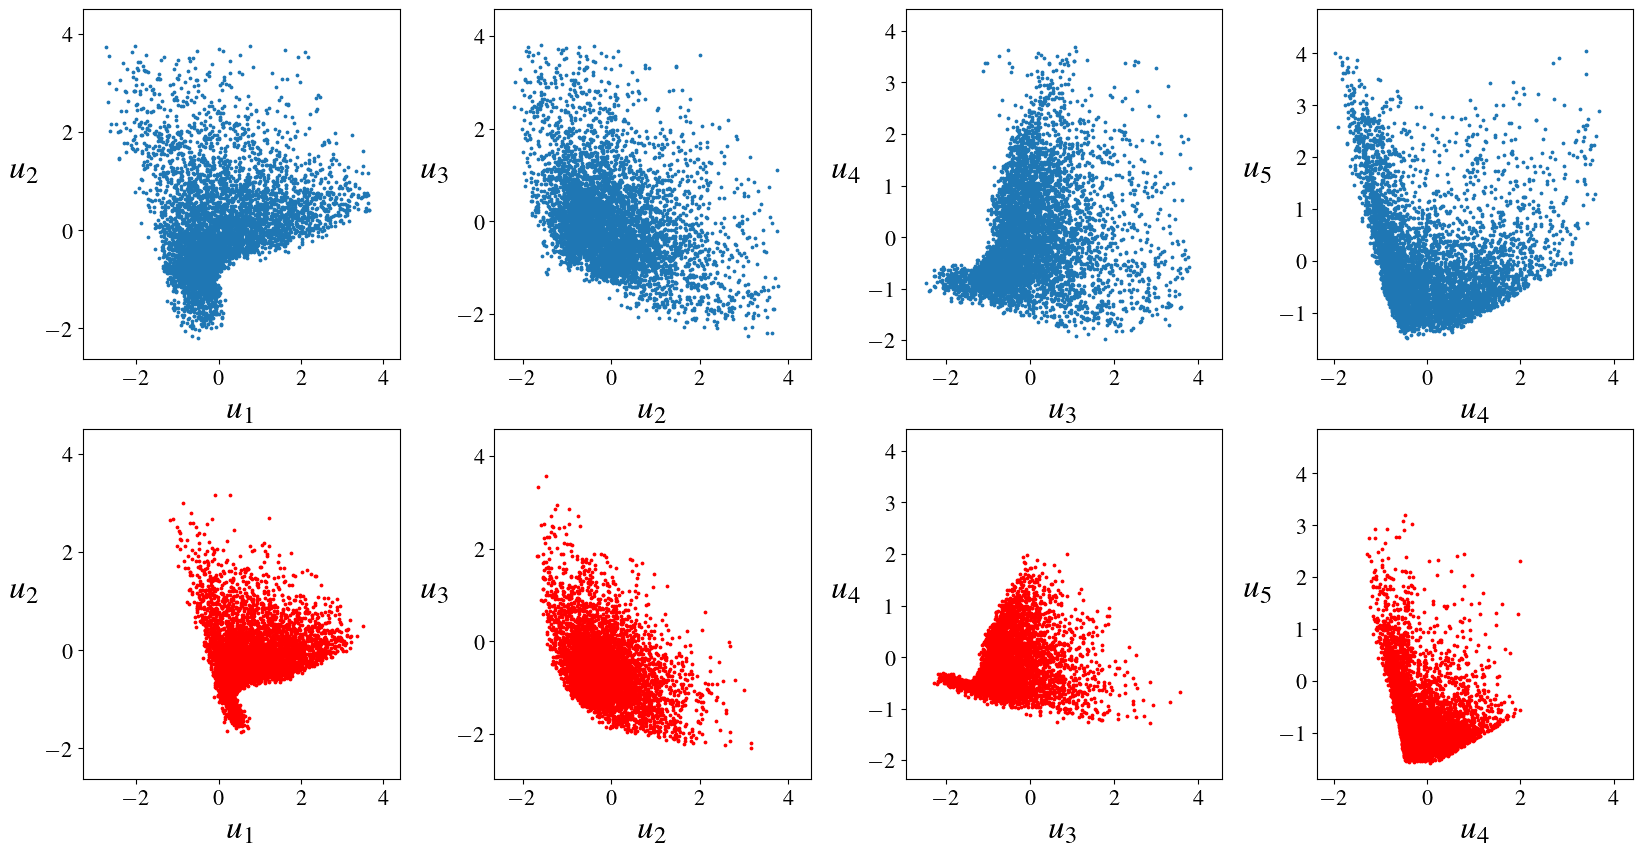

In [4]:
plot_data(x_LF, x_HF, dataset_name)

### Multi-fidelity model

#### Create graph and model instances

In [5]:
# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'n_components': None,
    'method': 'full',
    'k_nn': None,
    'corr_scale': None,
    'k_adj': 7,
    'p': 0.5,
    'q': 0.5,
}
g_LF = Graph(data=x_LF, **graph_config)

#### Perform spectral clustering

In [6]:
n_HF = 150
inds_train, labels = g_LF.cluster(n_HF)

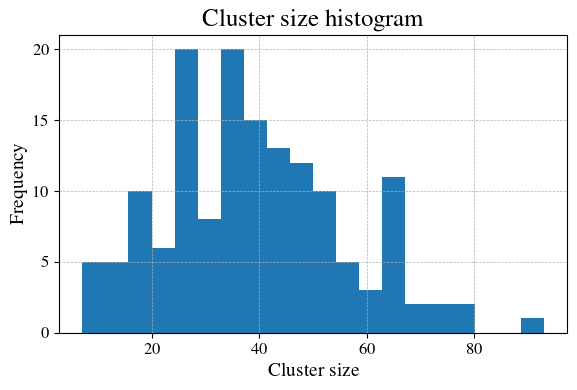

In [7]:
plot_cluster_size_hist(labels)

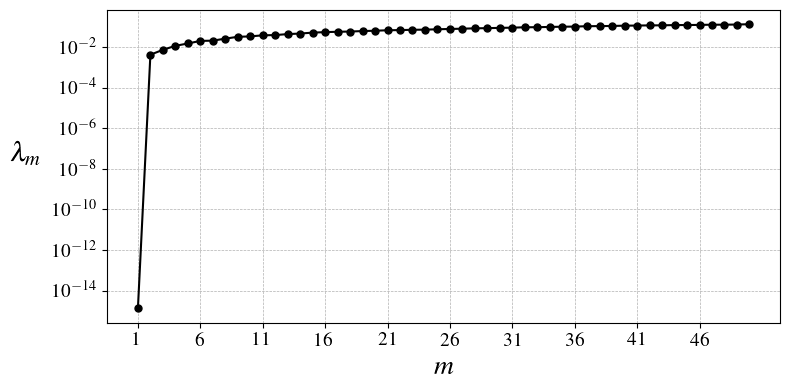

In [8]:
# Plot Laplacian spectrum
eigvals, eigvecs = g_LF.laplacian_eig()
plot_spectrum(eigvals, 50)

#### Fit and train the model

#### Split high-fidelity data

In [9]:
n_samples = x_HF.shape[0]
inds_test = np.delete(np.arange(n_samples), inds_train)
x_HF_train = x_HF[inds_train, :]
x_HF_test = x_HF[inds_test, :]

print(f"{x_HF_train.shape=}", f"{x_HF_test.shape=}")

x_HF_train.shape=(150, 5) x_HF_test.shape=(5685, 5)


In [10]:
# Create the model 
model_config = {
    'sigma': 0.01,
    'method': 'full',
}
model = MultiFidelityModel(**model_config)

fit_model = True

Iteration: 1, Loss: 0.019572465089694235, Gradient: -0.023711578117168557, Kappa: 0.0010000000000000002
Iteration: 2, Loss: 0.0004982839459539291, Gradient: -0.0011512883225608698, Kappa: 0.010709785023082192
Iteration: 3, Loss: 0.0003724145840419713, Gradient: -0.0009364214539443481, Kappa: 0.01208594353006608
Iteration: 4, Loss: 0.00028417135084906784, Gradient: -0.0007764372975631339, Kappa: 0.013400386514185968
Iteration: 5, Loss: 0.00022003969485190832, Gradient: -0.0006528872346771026, Kappa: 0.014660632989713129
Iteration: 6, Loss: 0.00017218371546506384, Gradient: -0.0005548192094829593, Kappa: 0.015871494872579408
Iteration: 7, Loss: 0.00013575466025150083, Gradient: -0.00047529929197427103, Kappa: 0.017036111171663447
Iteration: 8, Loss: 0.000107598096894878, Gradient: -0.0004097144228041909, Kappa: 0.018156523700172653
Iteration: 9, Loss: 8.55784621237495e-05, Gradient: -0.00035487207951286363, Kappa: 0.019234025314003127
Iteration: 10, Loss: 6.820225149259926e-05, Gradient:

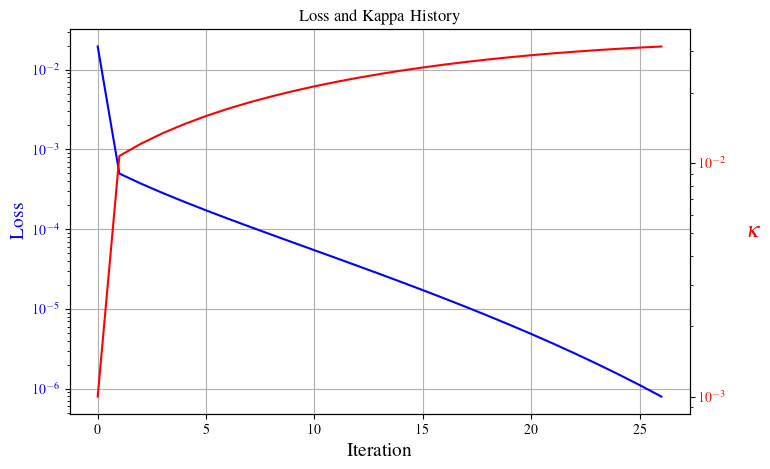

In [11]:
if fit_model:
    (x_MF, C_phi, dPhi), loss_history, kappa_history = model.fit_transform(
        g_LF,
        x_HF_train,
        inds_train,
        maxiter=50,
        step_size=1e2,
        step_decay_rate=1.05,
        ftol=1e-6,
        gtol=1e-8,
        verbose=True,
    )
    model.summary()

    plot_loss_and_kappa(loss_history, kappa_history)

else:
    from pathlib import Path

    notebook_path = Path.cwd()
    yaml_file_path = notebook_path.parent / 'data/model_configs.yaml'
    model_config = load_model_config(yaml_file_path, dataset_name)
    model = MultiFidelityModel(**model_config)
    
    if model_config:
        x_MF, C_phi, dPhi = model.transform(g_LF, x_HF_train, inds_train)
        model.summary()

Text(0.5, 1.0, 'Variance histogram for Soft body traction data')

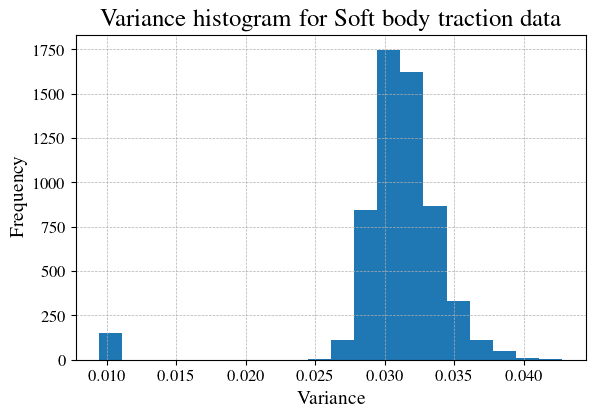

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(dPhi, bins=20)
ax.set_xlabel("Variance", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
ax.tick_params(axis="both", labelsize=12)
ax.set_title("Variance histogram for Soft body traction data", fontsize=18)

### Results

In [13]:
# Error Analysis for unseen test datadet
error_analysis(x_LF[inds_test], x_MF[inds_test], x_HF_test, component_wise=True,)

Component-wise mean relative l2 errors and Improvement Factor (IF)
-------------------------------------------------------------------
Error LF:         [98.96 62.53 75.74 92.36 76.42]
Error MF:         [16.18 19.44 16.99 18.54 23.87]
Percentage drop:  [83.65 68.91 77.57 79.93 68.77]%


In [14]:
# Error Analysis for the whole dataset
error_analysis(x_LF, x_MF, x_HF, component_wise=True,)

Component-wise mean relative l2 errors and Improvement Factor (IF)
-------------------------------------------------------------------
Error LF:         [98.51 62.55 75.53 92.62 76.45]
Error MF:         [15.74 18.95 16.55 18.09 23.28]
Percentage drop:  [84.02 69.71 78.09 80.46 69.54]%


In [15]:
# Error Analysis for the whole dataset in ambient space
X_mean = normalization_vars['X_mean']
X_scale = normalization_vars['X_scale']

X_LF = x_LF * X_scale + X_mean
X_HF = x_HF * X_scale + X_mean
X_MF = x_MF * X_scale + X_mean

error_analysis(X_LF, X_MF, X_HF, component_wise=True,)

Component-wise mean relative l2 errors and Improvement Factor (IF)
-------------------------------------------------------------------
Error LF:         [ 5.74  4.8   7.57  4.93 11.04]
Error MF:         [0.92 1.46 1.66 0.96 3.36]
Percentage drop:  [84.02 69.71 78.09 80.46 69.54]%


In [16]:
eLF, eMF = error_analysis(X_LF, X_MF, X_HF, component_wise=True, return_values=True,)


Component-wise mean relative l2 errors and Improvement Factor (IF)
-------------------------------------------------------------------
Error LF:         [ 5.74  4.8   7.57  4.93 11.04]
Error MF:         [0.92 1.46 1.66 0.96 3.36]
Percentage drop:  [84.02 69.71 78.09 80.46 69.54]%


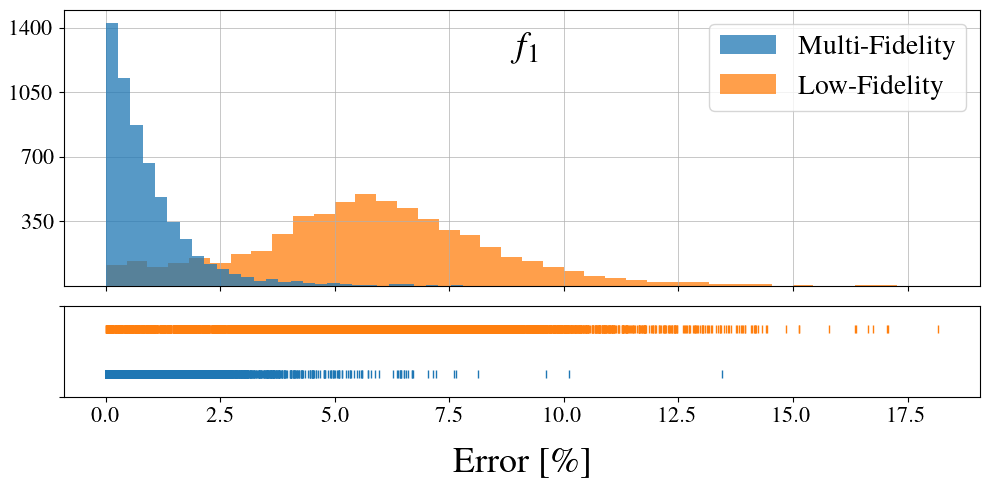

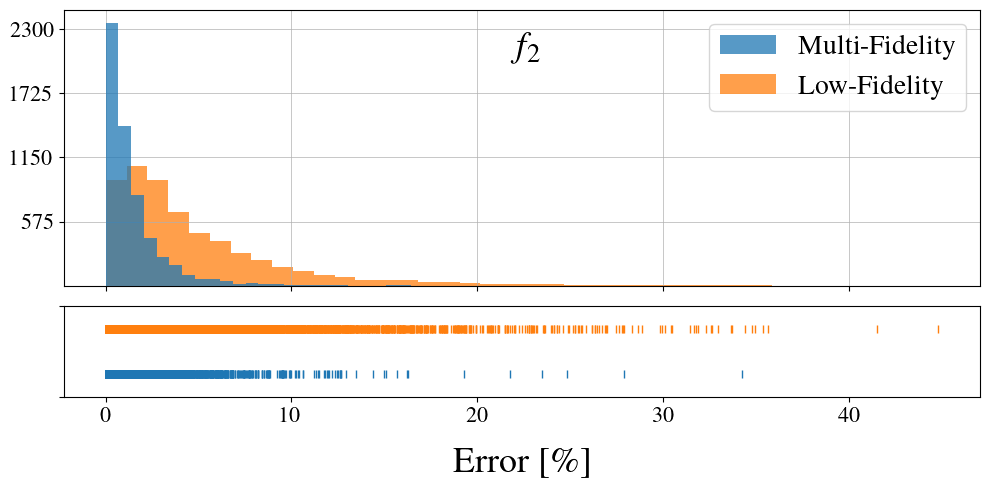

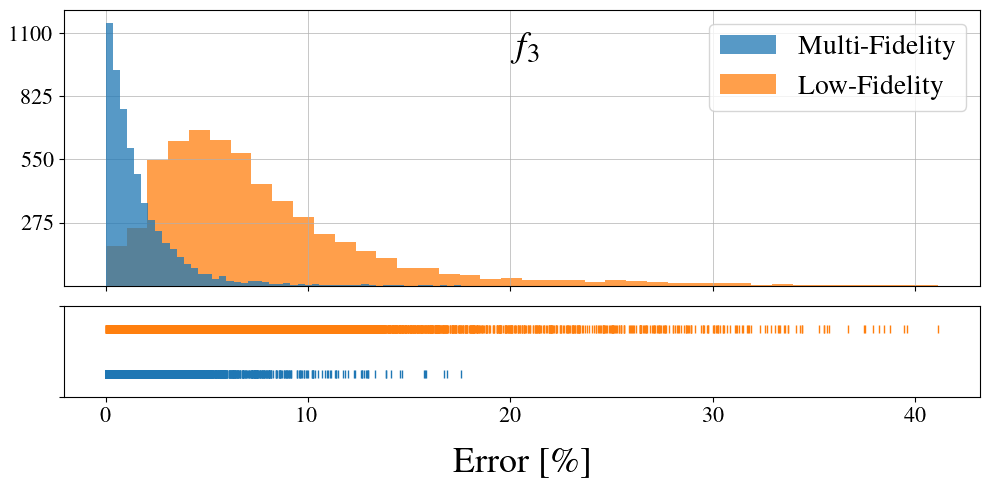

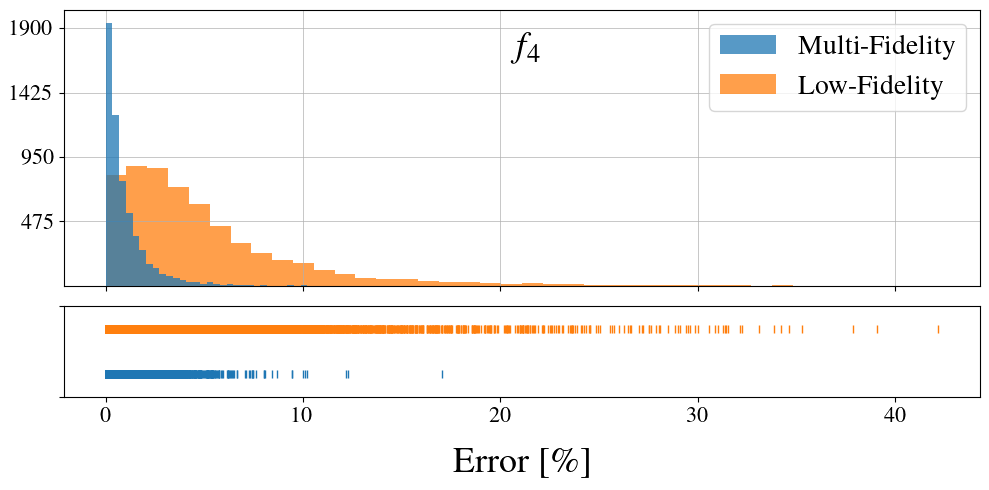

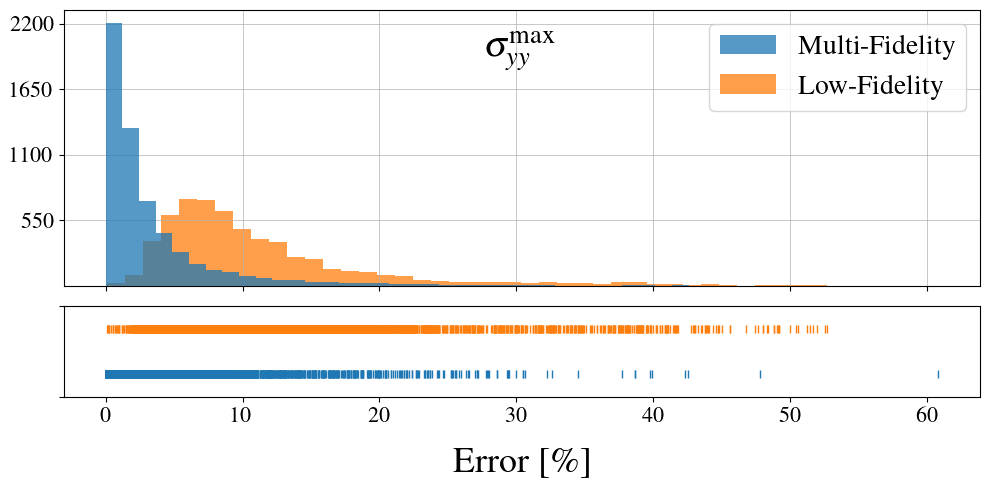

In [17]:
comps = [r"$f_1$", r"$f_2$", r"$f_3$", r"$f_4$", r"$\sigma_{yy}^{\mathrm{max}}$"]
for i in range(5):
    E_LF = 100 * np.linalg.norm(X_LF[:, i:i+1] - X_HF[:, i:i+1], axis=1) / (np.mean(np.linalg.norm(X_HF[:, i:i+1], axis=1)) + 1e-3)
    E_MF = 100 * np.linalg.norm(X_MF[:, i:i+1] - X_HF[:, i:i+1], axis=1) / (np.mean(np.linalg.norm(X_HF[:, i:i+1], axis=1)) + 1e-3)

    axs = plot_distributions(E_LF, E_MF, bins_LF=40, bins_MF=50, mask=None, return_axs=True)
    axs[0].set_title(f"{comps[i]}", y=0.8, fontsize=26,)

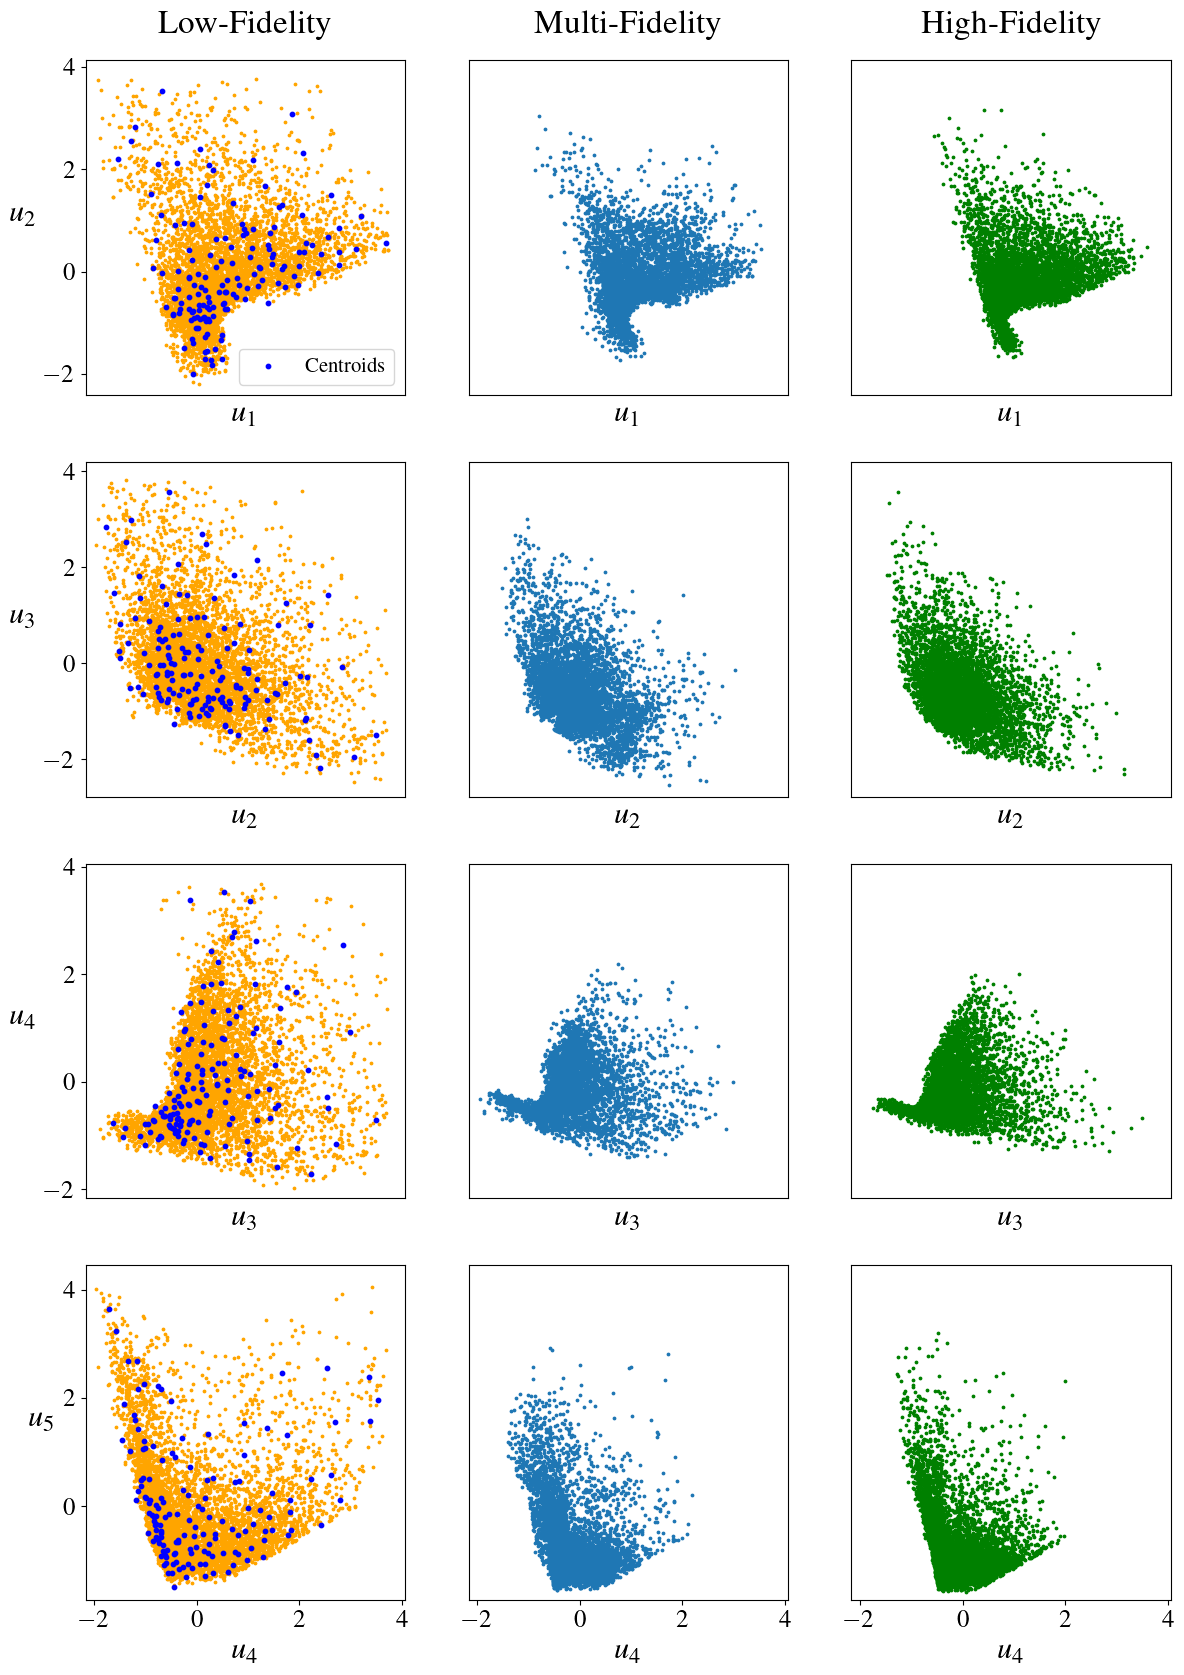

In [18]:
plot_mf_comparison(
    dataset_name=dataset_name,
    X_LF=x_LF,
    X_MF=x_MF,
    X_HF=x_HF,
    inds_centroids=inds_train,
)

### Explore UQ applications

In [19]:
import matplotlib.ticker as ticker

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [20]:
g_MF = Graph(data=x_MF, **graph_config)

In [21]:
_, eigevs = g_MF.laplacian_eig()
X = np.real(eigvecs[:, :n_HF])

In [22]:
import umap

X_umap = umap.UMAP(
    n_components=2,
    n_neighbors=40,
    min_dist=0.75,
    init='random', 
    random_state=42
).fit_transform(X)

/opt/homebrew/Caskroom/miniforge/base/envs/generic-env/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'UMAP of Elastic Body data (Case 1)')

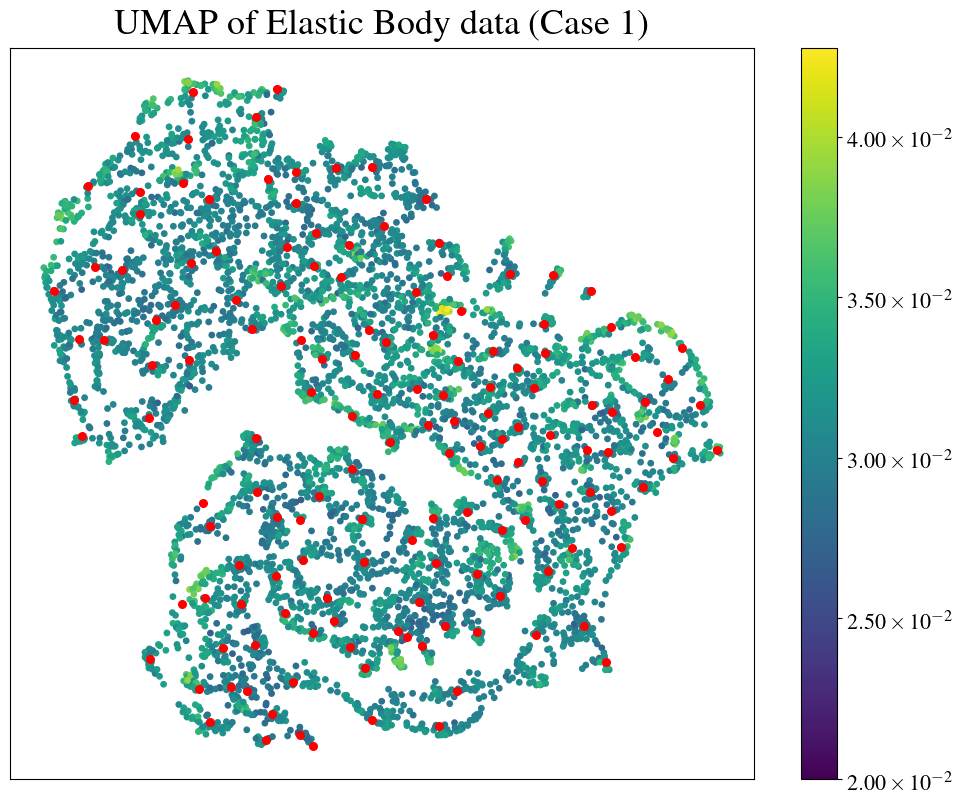

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9.5))
ax1 = ax.scatter(X_umap[:, 0], X_umap[:, 1], s=15, c=dPhi, vmin=0.02)
ax.scatter(X_umap[inds_train, 0], X_umap[inds_train, 1], s=30, c='r', marker='o')
cb = plt.colorbar(ax1, format=ticker.FuncFormatter(fmt))
cb.ax.tick_params(labelsize=16)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('UMAP of Elastic Body data (Case 1)', fontsize=26, pad=10)